In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [326]:
data = pd.read_csv('data.csv', encoding="ISO-8859-1")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# **Data Understanding**

**Variable Description**
- **InvoiceNo**    Code representing each unique transaction. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode**    Code uniquely assigned to each distinct product.
- **Description**  Description of each product.
- **Quantity** 	   The number of units of a product in a transaction.
- **InvoiceDate**  The date and time of the transaction.
- **UnitPrice**    The unit price of the product in sterling.
- **CustomerID**   Identifier uniquely assigned to each customer.
- **Country**      The country of the customer.

In [327]:
# information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


We notice that the dataset consists of 8 features, encompassing both string and numerical types. Specifically, there are 5 object (string) features and 3 numerical features. Additionally, it's evident that there are missing values present in the dataset, which we will address later on.

In [328]:
# some simple statistics
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


From the simple statistics provided, we can discern a significant disparity between the mean and standard deviation of the Quantity and UnitPrice features. The mean Quantity is approximately 9.55, while the standard deviation is substantially larger at around 218.08. Similarly, for the UnitPrice feature, the mean is approximately 4.61, with a considerably higher standard deviation of approximately 96.76. Such a pronounced gap between the mean and standard deviation suggests the presence of outliers within our dataset

In [329]:
# Statistics for categorical variables
data.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


In [330]:
# check the messing values in the data
percentage_missing =( data.isnull().sum() / data.shape[0] * 100)
percentage_missing

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Almost a quarter (25%) of the customers remain unidentified in the dataset. Additionally, there's a mere 0.25% of missing descriptions, which indicates potential data cleanliness issues.

# **Some Data Analysis**

- ### Which StockCode for product are most sold?


C:\Users\ismai\AppData\Local\Temp\ipykernel_8572\2148975645.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stockcode_counts.iloc[0:20].index,


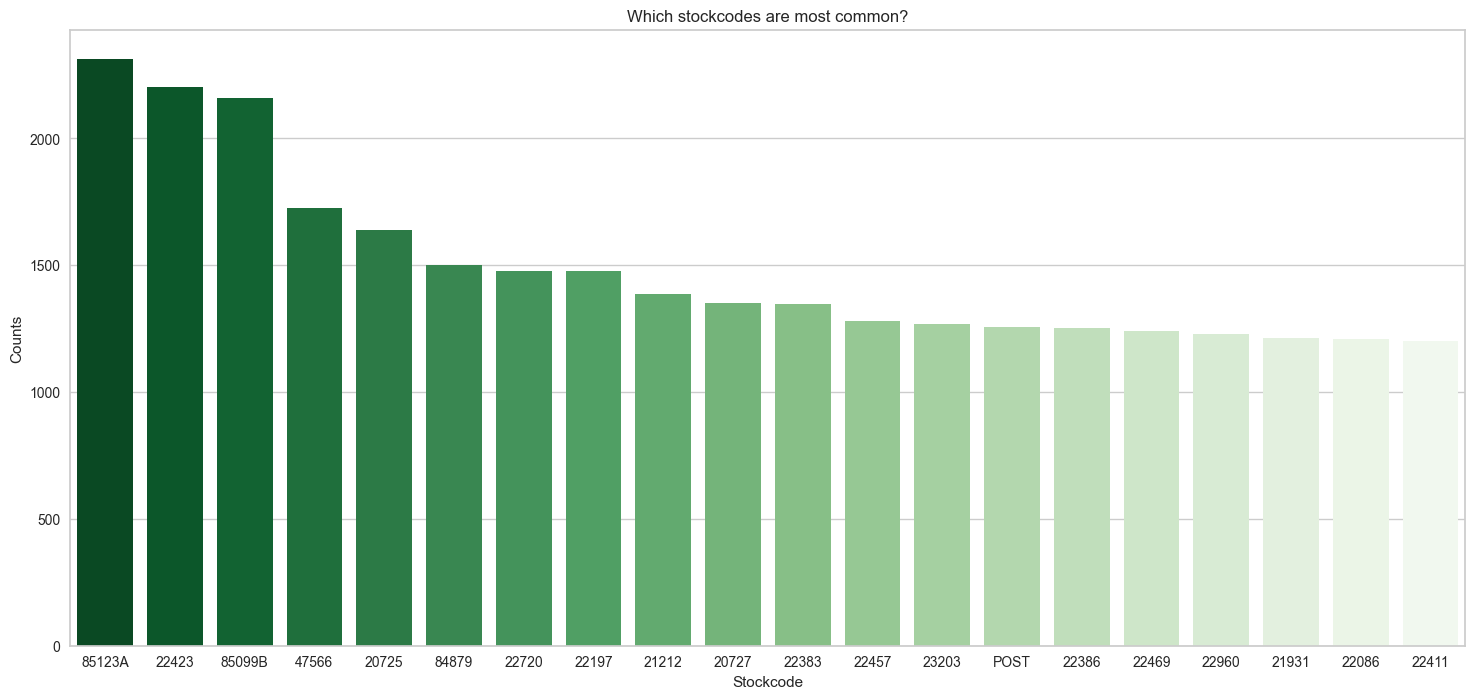

In [331]:
stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(18,8))  
sns.barplot(x=stockcode_counts.iloc[0:20].index,
            y=stockcode_counts.iloc[0:20].values,
            ax=ax, palette="Greens_r",
            legend=False)
ax.set_ylabel("Counts")
ax.set_xlabel("Stockcode")
ax.set_title("Which stockcodes are most common?")
plt.show() 

C:\Users\ismai\AppData\Local\Temp\ipykernel_8572\3462731100.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=description_counts.iloc[0:20].index,


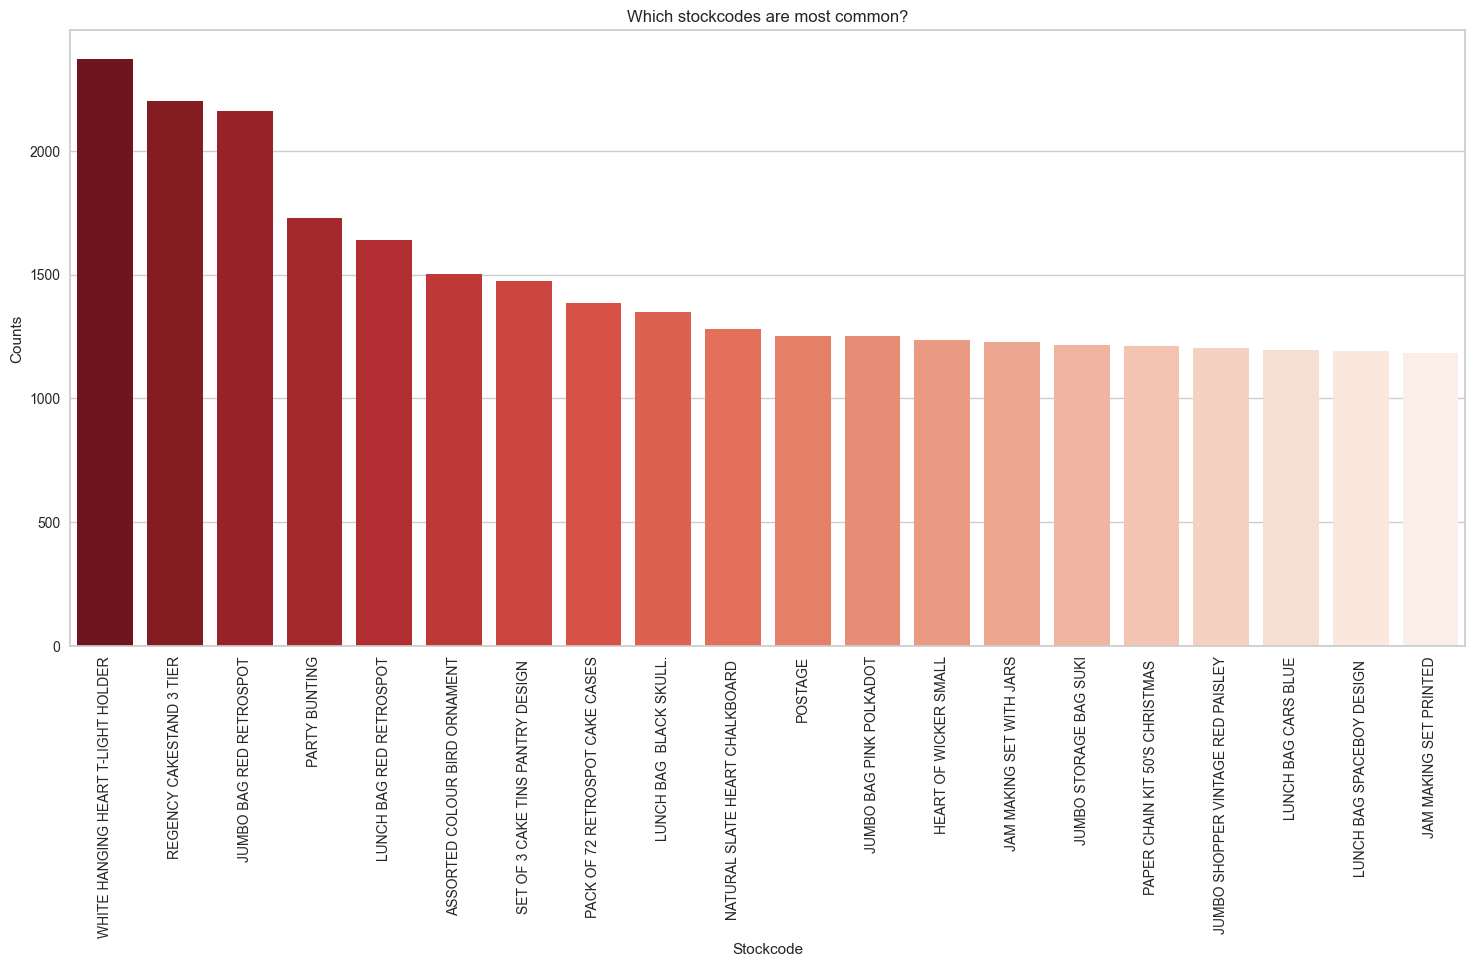

In [332]:
description_counts = data.Description.value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(18,8))  
sns.barplot(x=description_counts.iloc[0:20].index,
            y=description_counts.iloc[0:20].values,
            ax=ax, palette="Reds_r",
            legend=False)
ax.set_ylabel("Counts")
ax.set_xlabel("Stockcode")
ax.set_title("Which stockcodes are most common?")
plt.xticks(rotation=90);
plt.show() 

In [333]:
data['Description'].value_counts()[:3]

Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
Name: count, dtype: int64

The three most common products sold appear to be the following:

    1: WHITE HANGING HEART T-LIGHT HOLDER
    2: REGENCY CAKESTAND 3 TIER
    3: JUMBO BAG RED RETROSPOT

**"WHITE HANGING HEART T-LIGHT HOLDER"** emerges as the best-selling item, with a impressive quantity sold of 2369 units. Following closely is the **"REGENCY CAKESTAND 3 TIER"** with a substantial sales volume of 2200 units. Lastly, the **"JUMBO BAG RED RETROSPOT"** stands out with an remarkable quantity sold of 2159 units.

- ### Most Customers

C:\Users\ismai\AppData\Local\Temp\ipykernel_8572\2145033153.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_counts.values,


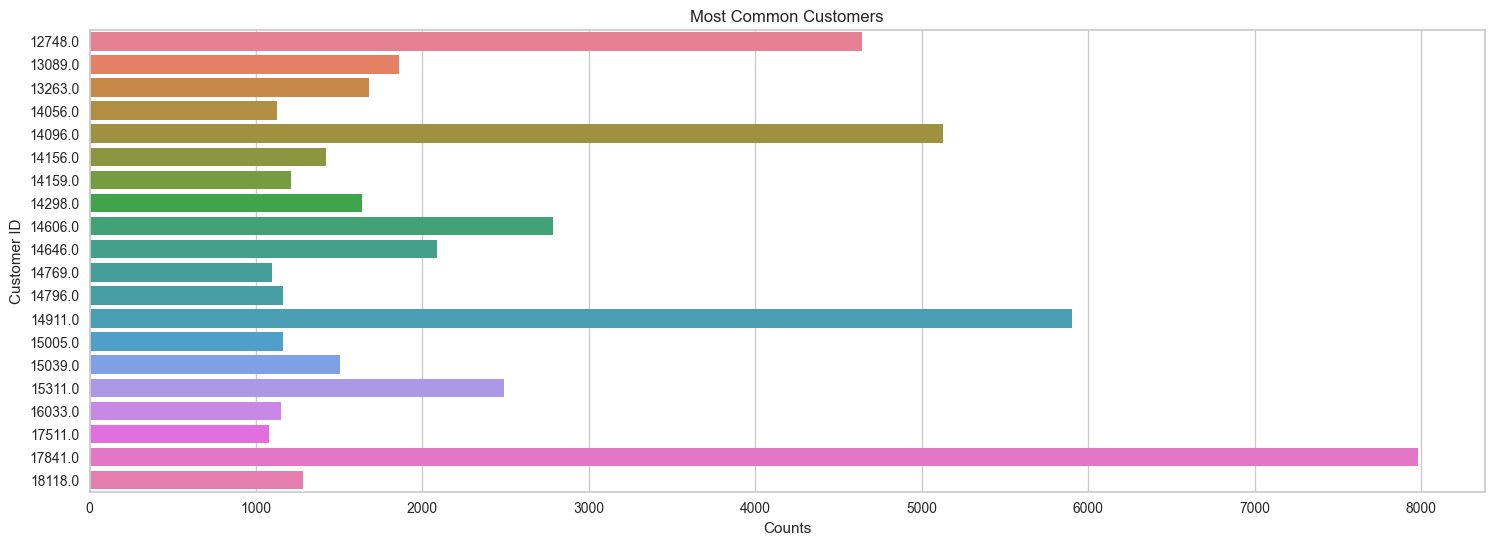

In [334]:
customer_counts = data.CustomerID.value_counts().sort_values(ascending=False)
customer_counts = customer_counts.iloc[0:20][::-1]  
fig, ax = plt.subplots(figsize=(18,6))  
colors = sns.color_palette("husl", len(customer_counts))
sns.barplot(x=customer_counts.values,
            y=customer_counts.index,
            ax=ax, 
            palette=colors, 
            orient='h')  

ax.set_xlabel("Counts")
ax.set_ylabel("Customer ID")
ax.set_title("Most Common Customers")
plt.show()

- ### Check the transactions

**InvoiceNo**    Code representing each unique transaction. If this code starts with letter 'c', it indicates a cancellation.

In [335]:
# Extracting rows where 'InvoiceNo' starts with 'C'
cancellation_data = data[data['InvoiceNo'].str.startswith('C')]

# Displaying the extracted data
cancellation_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


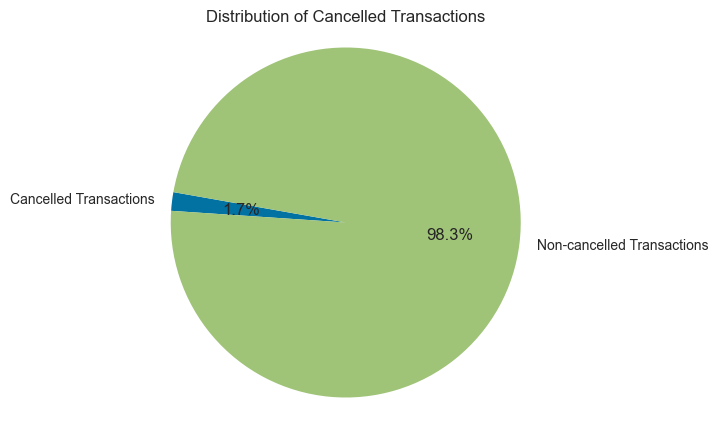

In [336]:
cancellation_transaction = data['InvoiceNo'].str.startswith('C').sum()
total_transactions = len(data['InvoiceNo'])
cancellation_percentage = (cancellation_transaction / total_transactions) * 100

# Plotting the pie chart
plt.figure(figsize=(6, 5))
plt.pie([cancellation_percentage, 100 - cancellation_percentage],
        labels=['Cancelled Transactions', 'Non-cancelled Transactions'],
        autopct='%1.1f%%', startangle=170)
plt.title('Distribution of Cancelled Transactions')
plt.axis('equal') 
plt.show()


Out of all unique transactions, only 1, or roughly 1.7%, are cancellations, leaving the vast majority as non-cancelled transactions. This low percentage suggests a well-managed order fulfillment process with minimal errors or customer dissatisfaction

In [337]:
# copy the data and leve the original with no modifecation yet 
df = data.copy()

In [338]:
# Convert 'InvoiceDate' column to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract year, month, and day and add them as separate columns
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] =df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day

# Display the updated DataFrame
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1


In [339]:
year_10 = df.query('Year ==2010')['Quantity'].sum()
year_11 = df.query('Year ==2011')['Quantity'].sum()
print(f'quantity solde in 2010: {year_10}')
print(f'quantity solde in 2011: {year_11}')

quantity solde in 2010: 342228
quantity solde in 2011: 4834222


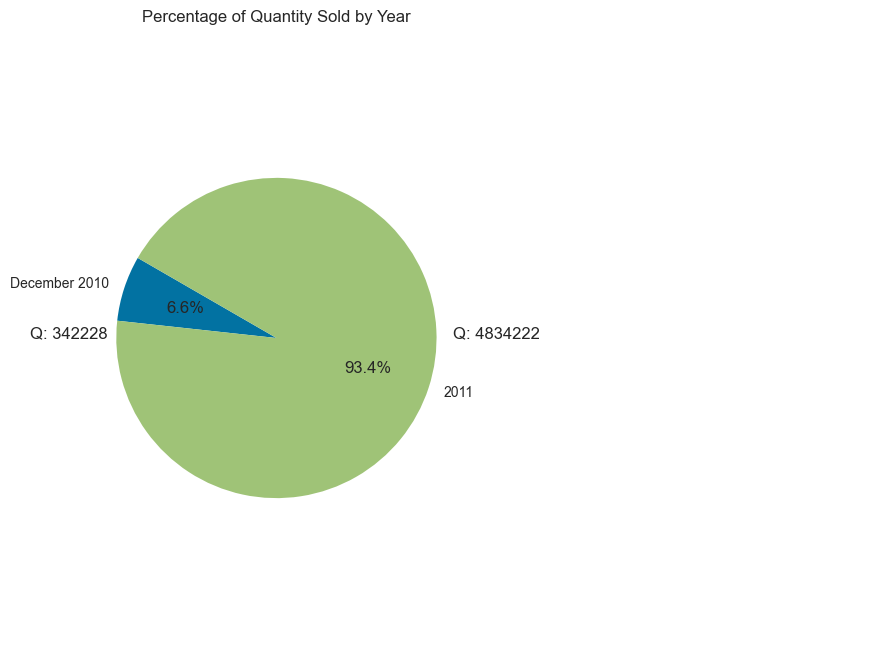

In [340]:
# Calculate total quantity sold
total_quantity_10 = year_10
total_quantity_11 = year_11

# Calculate percentages
percentage_10 = (year_10 / (year_10 + year_11)) * 100
percentage_11 = (year_11 / (year_10 + year_11)) * 100

# Plotting the pie chart
plt.figure(figsize=(10, 8))

# Plotting the pie chart
plt.subplot(121)
plt.pie([percentage_10, percentage_11], labels=['December 2010', '2011'], autopct='%1.1f%%', startangle=150)
plt.title('Percentage of Quantity Sold by Year')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adding total quantity sold outside the pie chart
plt.subplot(122)
plt.text(-1.4, 0.5, f'Q: {total_quantity_10}', fontsize=12)
plt.text(-0.2, 0.5, f'Q: {total_quantity_11}', fontsize=12)
plt.axis('off')  # Turn off axis for annotation subplot

plt.show()


The data indicates a notable difference in sales between December 2010 and the entirety of 2011. In December 2010 alone, a total of 342,228 items were sold, while in 2011, sales substantially increased to 4,834,222 items. This significant growth in sales from December 2010 to 2011 suggests successful strategies or shifts in consumer demand during that period. The combined total quantity sold over the two periods amounts to 5,176,450 items, highlighting an overall positive trend.

- ### Comparison between the Quantity sold and the Qales revenue for each month in 2011

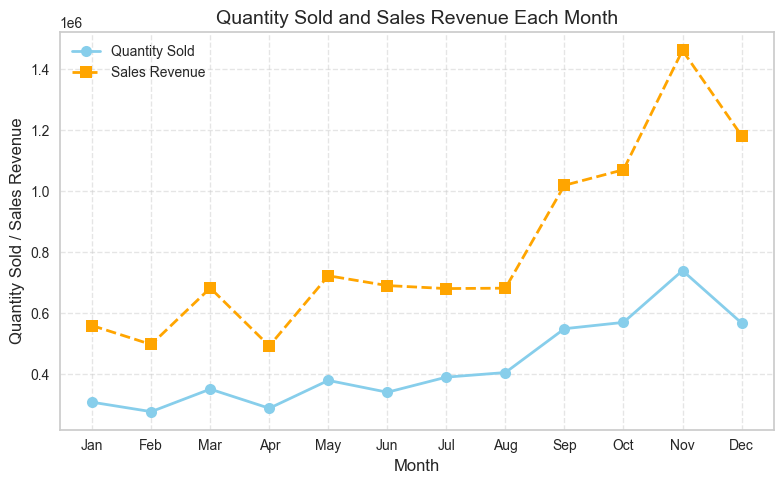

In [341]:
# Calculate sales revenue by multiplying quantity sold by unit price
df['SalesRevenue'] = df['Quantity'] * df['UnitPrice']

# Group by month and sum the quantities sold and sales revenue
monthly_data = df.groupby('Month').agg({'Quantity':'sum', 'SalesRevenue':'sum'})

# Plotting the line chart with stylish customization
plt.figure(figsize=(8, 5))
plt.plot(monthly_data.index, monthly_data['Quantity'], marker='o', linestyle='-', color='skyblue', label='Quantity Sold', linewidth=2, markersize=8)
plt.plot(monthly_data.index, monthly_data['SalesRevenue'], marker='s', linestyle='--', color='orange', label='Sales Revenue', linewidth=2, markersize=8)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Quantity Sold / Sales Revenue', fontsize=12)
plt.title('Quantity Sold and Sales Revenue Each Month', fontsize=14)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [342]:
# revenu by month
monthly_data

,Quantity,SalesRevenue
Month,,
1,308966,560000.260
2,277989,498062.650
3,351872,683267.080
4,289098,493207.121
5,380391,723333.510
6,341623,691123.120
7,391116,681300.111
8,406199,682680.510
9,549817,1019687.622


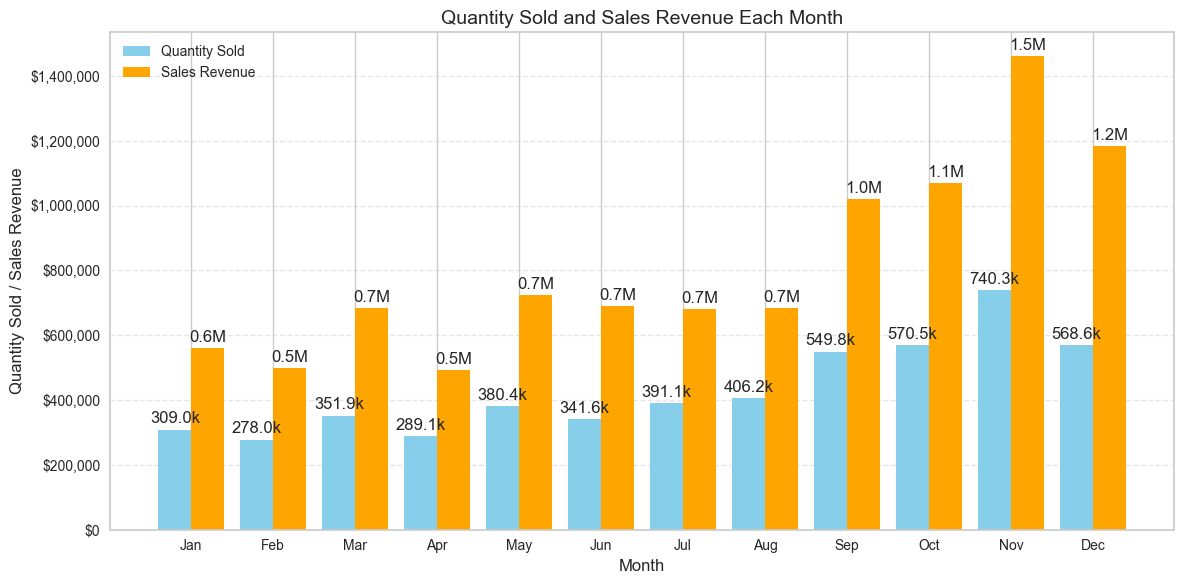

In [343]:
import matplotlib.ticker as mtick

datas = {
    'Month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'Quantity': [308966, 277989, 351872, 289098, 380391, 341623, 391116, 406199, 549817, 570532, 740286, 568561],
    'SalesRevenue': [560000.26, 498062.65, 683267.08, 493207.12, 723333.51, 691123.12, 681300.11, 682680.51, 1019687.622, 1070704.67, 1461756.25, 1182625.03]
}

# Create DataFrame
dfs = pd.DataFrame(datas)

# Plotting the bar chart
plt.figure(figsize=(12, 6))

# Plotting quantity sold for all months
plt.bar(dfs['Month'] - 0.2, dfs['Quantity'], width=0.4, color='skyblue', label='Quantity Sold')

# Plotting sales revenue
plt.bar(dfs['Month'] + 0.2, dfs['SalesRevenue'], width=0.4, color='orange', label='Sales Revenue')

# Adding numbers on top of each bar
for i, val in enumerate(dfs['Quantity']):
    plt.text(i + 0.8, val + 10000, f'{val/1e3:.1f}k', ha='center', va='bottom')

for i, val in enumerate(dfs['SalesRevenue']):
    plt.text(i + 1.2, val + 10000, f'{val/1e6:.1f}M', ha='center', va='bottom')

plt.xlabel('Month', fontsize=12)
plt.ylabel('Quantity Sold / Sales Revenue', fontsize=12)
plt.title('Quantity Sold and Sales Revenue Each Month', fontsize=14)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()


The bar chart presents a comparison between the quantity sold and the sales revenue for each month, based on the provided information.

In January, although the quantity sold is relatively high at 308,966 items, the corresponding sales revenue stands at $560,000.26, suggesting a balance between sales volume and revenue generation.

February continues this trend with a slightly lower quantity sold of 277,989 items, resulting in a sales revenue of $498,062.65.

March sees a significant increase in both quantity sold and sales revenue, with 351,872 items sold, contributing to a revenue of $683,267.08. This suggests a strong demand for products during this period, leading to increased sales revenue.

April experiences a slight decrease in both quantity sold and revenue compared to March, with 289,098 items sold and revenue of $493,207.12.

May marks a notable upsurge in both quantity sold and sales revenue, with 380,391 items sold and revenue reaching $723,333.51. This suggests heightened consumer activity and increased spending during this period.

June maintains a similar level of sales activity as May, with 341,623 items sold and revenue totaling $691,123.12.

July and August see further increases in both quantity sold and revenue, indicating sustained growth in sales performance during the summer months.

September witnesses a substantial spike in both quantity sold and revenue, with 549,817 items sold and revenue soaring to $1,019,687.62. This significant increase may be attributed to various factors such as seasonal demand, promotional activities, or new product launches.

October and November continue this upward trajectory, with sales reaching 570,532 and 740,286 items respectively, and corresponding revenues of $1,070,704.67 and $1,461,756.25. These months likely benefit from increased consumer spending during the holiday season.

December concludes the year with strong sales performance, with 568,561 items sold and revenue amounting to $1,182,625.03, indicating robust demand and revenue generation during the festive period.

Overall, the bar chart highlights the fluctuations in sales volume and revenue throughout the year, providing insights into consumer behavior, seasonal trends, and the performance of the business over time.

- ### Top 10 Countries by Sales Revenue

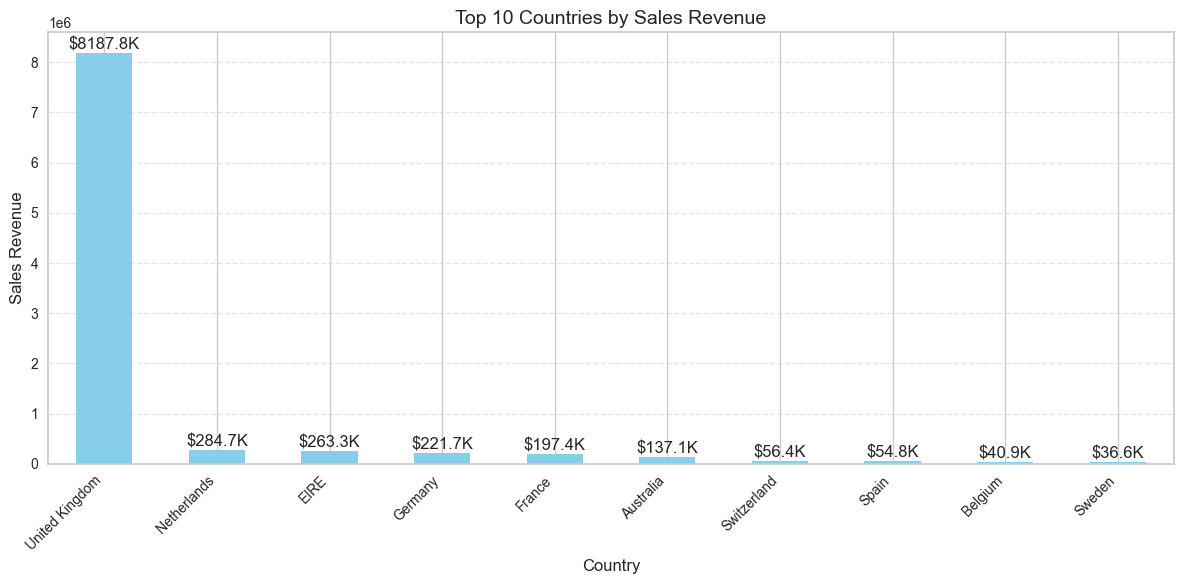

In [344]:
# Group by country and sum the sales revenue
revenue_by_country = df.groupby('Country')['SalesRevenue'].sum()

# Select the top 10 countries with the highest revenue
top_10_countries = revenue_by_country.nlargest(10)

# Plotting the bar chart
plt.figure(figsize=(12, 6))
top_10_countries.plot(kind='bar', color='skyblue')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Sales Revenue', fontsize=12)
plt.title('Top 10 Countries by Sales Revenue', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding numbers on top of each bar
for i, val in enumerate(top_10_countries):
    plt.text(i, val + 10000, f'${val/1e3:.1f}K', ha='center', va='bottom')

plt.tight_layout()
plt.show()


The bar chart depicts the top 10 countries contributing the highest sales revenue to the company, with the United Kingdom leading by a substantial margin, generating a revenue of $8,187,806.36. Following closely, the Netherlands and EIRE stand out with revenues of $284,661.54 and $263,276.82 respectively. Germany and France also make significant contributions, with revenues of $221,698.21 and $197,403.90 respectively.

# **Data Preprocessing**

In [345]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


- ### "Handling Missing Values"

In [346]:
percentage_missing = round((data.isnull().sum() / data.shape[0] * 100),2)
percentage_missing

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

The CustomerID column, vital for clustering customers and building recommendation systems, holds nearly a quarter of missing data. Imputing such a large portion of missing values risks introducing bias or noise into the analysis. Given the importance of accurate customer identifiers for clustering based on behavior and preferences, it's prudent to remove rows with missing CustomerIDs to preserve cluster integrity and analysis accuracy.

For Description missing percentage is quite low, it would be prudent to remove the rows with missing Descriptions to avoid propagating errors and inconsistencies into the subsequent analyses.

In [347]:
# drop the massing values
data = data.dropna()
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

- ### "Check Duplicates"

In [348]:
# check percentage of duplicated rows in our data
duplicate_rows = data[data.duplicated(keep=False)]
percentage_duplicat = round((len(duplicate_rows)/len(data)*100),2)
print(f"prcentage of duplicated rows {percentage_duplicat}%")


prcentage of duplicated rows 2.47%


We have identified that 2.47% of the rows in the dataset are duplicates. To enhance performance when implementing the segmentation and recommendation system algorithms, it's advisable to remove these duplicates. While the impact on the overall dataset size may be minimal, this action can significantly improve the efficiency and accuracy of our system.

In [349]:
# Removing duplicate rows
data.drop_duplicates(inplace=True)

In [350]:
data.shape

(401604, 8)

- ### Features investegation

**StockCodes**

In [351]:
data['StockCode'].value_counts()

StockCode
85123A    2065
22423     1894
85099B    1659
47566     1409
84879     1405
          ... 
90104        1
90135        1
90027D       1
90027A       1
84746        1
Name: count, Length: 3684, dtype: int64

In [352]:
unique_stock_codes = data['StockCode'].unique()

anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]
anomalous_stock_codes

['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']

In [353]:
# percentage of records with these anomalous stock codes

# Calculating the percentage of records with these stock codes
percentage_anomalous = (data['StockCode'].isin(anomalous_stock_codes).sum() / len(data) * 100)

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


Remove rows with these anomalous stock codes from the dataset before proceeding with further analysis and model development

In [354]:
# Removing rows with anomalous stock codes from the dataset
data = data[~data['StockCode'].isin(anomalous_stock_codes)]
data.shape

(399689, 8)

**Description**

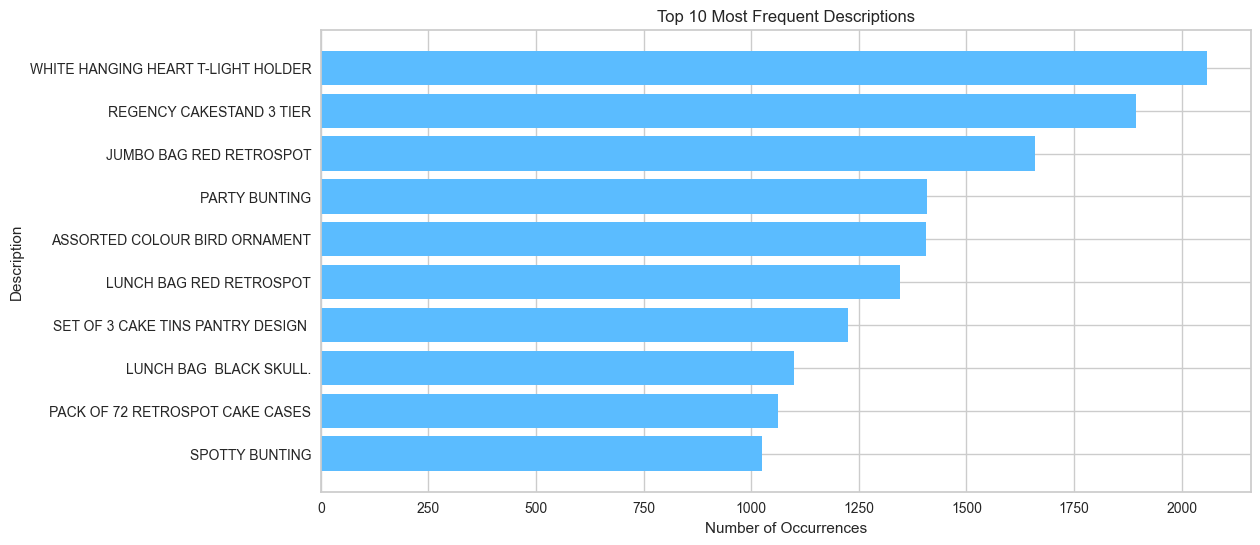

In [355]:
# Calculate the occurrence of each unique description and sort them
description_counts = data['Description'].value_counts()

# Get the top 30 descriptions
top_10_descriptions = description_counts[:10]

# Plotting
plt.figure(figsize=(12,6))
plt.barh(top_10_descriptions.index[::-1], top_10_descriptions.values[::-1], color='#5BBCFF')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 10 Most Frequent Descriptions')

# Show the plot
plt.show()

In [356]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = data['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


After examining the descriptions with lowercase characters, it's apparent that certain entries like "Next Day Carriage" and "High Resolution Image" are not typical product descriptions. These entries appear to be unrelated to the products themselves, possibly representing other types of information or service details.

In [357]:
# Remove rows with service-related information in the description
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

data = data[~data['Description'].isin(service_related_descriptions)]
data.shape

(399606, 8)

**UnitPrice**

In [358]:
data['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

The presence of zero as the minimum unit price value implies that certain transactions may involve items priced at zero. This could indicate the presence of either free items or data entry errors.

In [359]:
data[data['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


WE GOT 33 PRODUCT WHIT ZEROS UNITPRICE

In [360]:
# Removing records with a unit price of zero to avoid potential data entry errors
data = data[data['UnitPrice']>0]
data.shape

(399573, 8)

# RFM Features

RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:

    Recency (R): This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.

    Frequency (F): This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.

    Monetary (M): This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

Together, these metrics help in understanding a customer's buying behavior and preferences, which is pivotal in personalizing marketing strategies and creating a recommendation system.


In [361]:
# Convert InvoiceDate to datetime type
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
data['InvoiceDay'] = data['InvoiceDate'].dt.date

In [362]:
# Find the most recent purchase date for each customer
customer_data = data.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = data['InvoiceDay'].max()

In [363]:
# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [364]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


Frequency (F)

In [365]:
# Calculate the total number of transactions made by each customer
total_transactions = data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = data.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


Monetary

In [366]:
# Calculate the total spend by each customer
data['Total_Spend'] = data.loc[:,'UnitPrice'] * data.loc[:,'Quantity']
total_spend = data.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


**Product Diversity**

In this step, we are going to understand the diversity in the product purchase behavior of customers. Understanding product diversity can help in crafting personalized marketing strategies and product recommendations. Here, I am going to define the following feature:

    Unique Products Purchased: This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [367]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = data.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


#### ""Behavioral Features""

In this step, our goal is to delve into and capture customers' shopping patterns and behaviors. Introducing the following features can provide valuable insights into when and how customers prefer to shop:

    Average Days Between Purchases: This feature indicates the average duration between a customer's consecutive purchases. Understanding this can help predict when a customer is likely to make their next purchase, which is crucial for targeted marketing and personalized promotions.

    Favorite Shopping Day: This identifies the day of the week when a customer tends to shop the most. Knowing this can help identify preferred shopping days among different customer segments, enabling optimization of marketing strategies and promotions for specific days.

    Favorite Shopping Hour: This signifies the hour of the day when a customer is most active in shopping. Identifying the preferred shopping hour aids in optimizing the timing of marketing campaigns and promotions to align with customers' peak activity times.

By integrating these behavioral features into our dataset, we can develop a more comprehensive understanding of our customers. This, in turn, can enhance the effectiveness of clustering algorithms, resulting in more meaningful customer segmentation and ultimately improving marketing strategies and customer experiences.

In [368]:
# Extract day of week and hour from InvoiceDate
data['Day_Of_Week'] = data.loc[:, 'InvoiceDate'].dt.dayofweek
data['Hour'] = data.loc[:, 'InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = data.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = data.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = data.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

C:\Users\ismai\AppData\Local\Temp\ipykernel_8572\2265984063.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  days_between_purchases = data.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


### Geographic Features

This step introduces a crucial geographic feature: "Country." Understanding where customers are located helps us grasp region-specific buying habits and preferences. This insight is vital for tailoring marketing strategies, optimizing inventory, and streamlining logistics, especially in online retail where shipping is pivotal.

In [369]:
data['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: proportion, dtype: float64

Considering that the majority (89%) of transactions originate from the United Kingdom, we could create a binary feature indicating whether a transaction is from the UK or not. This simplification can streamline the clustering process, particularly for algorithms like K-means that are sensitive to the dimensionality of the feature space. By doing so, we retain essential geographical information while reducing computational complexity.

In [370]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = data.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


### Cancellation Insights

In this step, I'll explore customers' cancellation patterns to enrich our customer segmentation model with the following features:

    Cancellation Frequency: This metric counts the total number of transactions a customer has canceled. Understanding cancellation frequency helps identify customers prone to canceling transactions, potentially indicating dissatisfaction or other issues. This insight enables tailored strategies to reduce cancellations and boost overall customer satisfaction.

    Cancellation Rate: This metric calculates the proportion of canceled transactions out of all transactions for each customer. It offers a normalized view of cancellation behavior, highlighting segments with high cancellation rates. Identifying such segments allows for targeted strategies aimed at improving the shopping experience and mitigating cancellation rates.

By integrating these cancellation insights into our dataset, we develop a more comprehensive understanding of customer behavior, facilitating the creation of more nuanced and effective customer segmentation strategies.

In [371]:
# Calculate the total number of transactions made by each customer
total_transactions = data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Add transaction status
data['Transaction_Status'] = data.loc[:,"InvoiceNo"].str.startswith('C').apply(lambda x: "NoCancelled" if x == False else "Cancelled")

In [372]:
# Calculate the number of cancelled transactions for each customer
cancelled_transactions = data[data['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

In [ ]:
# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

In [400]:
customer_data = customer_data.drop(["Cancellation_Frequency_x", "Cancellation_Frequency_y"],axis=1)
# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Rate,Cancellation_Frequency
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,0.5,1.0
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


### Seasonality & Trends

In this step, we're analyzing seasonal trends and spending behaviors to inform targeted marketing strategies and enhance customer satisfaction. Key features include:

    Monthly Spending Mean: Reflects average monthly spending, indicating general purchasing habits.

    Monthly Spending Standard Deviation: Measures variability in monthly spending, helping identify fluctuating purchase patterns.

    Spending Trend: Calculates the slope of spending over time, revealing changes in customer behavior.

By incorporating these insights, we can develop precise customer segments for tailored marketing campaigns, maximizing their effectiveness and improving overall customer engagement.

In [401]:
# Extract month and year from InvoiceDate
data['Year'] = data.loc[:,'InvoiceDate'].dt.year
data['Month'] = data.loc[:,'InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = data.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Rate,Cancellation_Frequency,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,0.5,1.0,0.000000,NaN,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,NaN,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,NaN,0.000000


In [404]:
# we got error wen fill the null value so we try it again
customer_data['Monthly_Spending_Std'] = customer_data['Monthly_Spending_Std'].fillna(0)
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Rate,Cancellation_Frequency,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,0.5,1.0,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [405]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [407]:
customer_data.head(7)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Rate,Cancellation_Frequency,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,0.5,1,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0.0,0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0.0,0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0.0,0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0.0,0,294.4,0.0,0.0
5,12352.0,36,8,463,1265.41,158.17625,57,3.13253,1,14,0,0.125,1,316.3525,134.700629,9.351
6,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,0.0,0,89.0,0.0,0.0


In [408]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4362 entries, 0 to 4361
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4362 non-null   string 
 1   Days_Since_Last_Purchase        4362 non-null   Int64  
 2   Total_Transactions              4362 non-null   Int64  
 3   Total_Products_Purchased        4362 non-null   Int64  
 4   Total_Spend                     4362 non-null   Float64
 5   Average_Transaction_Value       4362 non-null   Float64
 6   Unique_Products_Purchased       4362 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4362 non-null   Int32  
 9   Hour                            4362 non-null   Int32  
 10  Is_UK                           4362 non-null   Int64  
 11  Cancellation_Rate               4362 non-null   Float64
 12  Cancellation_Frequency          43

### Customer Dataset Description:
**Variable 	Description*
- **CustomerID** 	Identifier uniquely assigned to each customer, used to distinguish individual customers.
- **Days_Since_Last_Purchase** 	The number of days that have passed since the customer's last purchase.
- **Total_Transactions** 	The total number of transactions made by the customer.
- **Total_Products_Purchased** 	The total quantity of products purchased by the customer across all transactions.
- **Total_Spend** 	The total amount of money the customer has spent across all transactions.
- **Average_Transaction_Value** 	The average value of the customer's transactions, calculated as total spend divided by the number of transactions.
- **Unique_Products_Purchased** 	The number of different products the customer has purchased.
- **Average_Days_Between_Purchases** 	The average number of days between consecutive purchases made by the customer.
- **Day_Of_Week** 	The day of the week when the customer prefers to shop, represented numerically (0 for Monday, 6 for Sunday).
- **Hour** 	The hour of the day when the customer prefers to shop, represented in a 24-hour format.
- **Is_UK** 	A binary variable indicating whether the customer is based in the UK (1) or not (0).
- **Cancellation_Frequency** 	The total number of transactions that the customer has cancelled.
- **Cancellation_Rate** 	The proportion of transactions that the customer has cancelled, calculated as cancellation frequency divided by total transactions.
- **Monthly_Spending_Mean** 	The average monthly spending of the customer.
- **Monthly_Spending_Std** 	The standard deviation of the customer's monthly spending, indicating the variability in their spending pattern.
- **Spending_Trend** 	A numerical representation of the trend in the customer's spending over time. A positive value indicates an increasing trend, a negative value indicates a decreasing trend, and a value close to zero indicates a stable trend.

####  Isolation Forest algorithm for Outlier Detection and Treatment

In [411]:
customer_data.iloc[:, 1:]

,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Rate,Cancellation_Frequency,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,325,2,0,0.0,0.0,1,0.0,1,10,1,0.5,1,0.0,0.0,0.0
1,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0.0,0,615.714286,341.070789,4.486071
2,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0.0,0,359.31,203.875689,-100.884
3,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0.0,0,1457.55,0.0,0.0
4,310,1,196,294.4,294.4,16,0.0,2,16,0,0.0,0,294.4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4357,277,1,45,180.6,180.6,10,0.0,0,9,1,0.0,0,180.6,0.0,0.0
4358,180,1,54,80.82,80.82,7,0.0,6,10,1,0.0,0,80.82,0.0,0.0
4359,7,3,98,176.6,58.866667,12,9.916667,4,13,1,0.333333,1,88.3,14.792674,-20.92
4360,3,16,1355,2039.58,127.47375,262,0.465181,3,14,1,0.0,0,203.958,165.798738,22.319273


In [414]:
customer_data.dropna(inplace=True)

In [415]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Rate,Cancellation_Frequency,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,0.5,1,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0.0,0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0.0,0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0.0,0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0.0,0,294.4,0.0,0.0,1,0


Following the application of the Isolation Forest algorithm, we've successfully identified outliers and denoted them in a new column called Is_Outlier. Additionally, we've computed outlier scores, representing the anomaly score for each record.

Next, we'll visualize the distribution of these scores alongside the count of inliers and outliers detected by the model.

- #### Separate the outliers for analysis

In [417]:
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

customer_data_cleaned.shape[0]

4067

- Correlation 

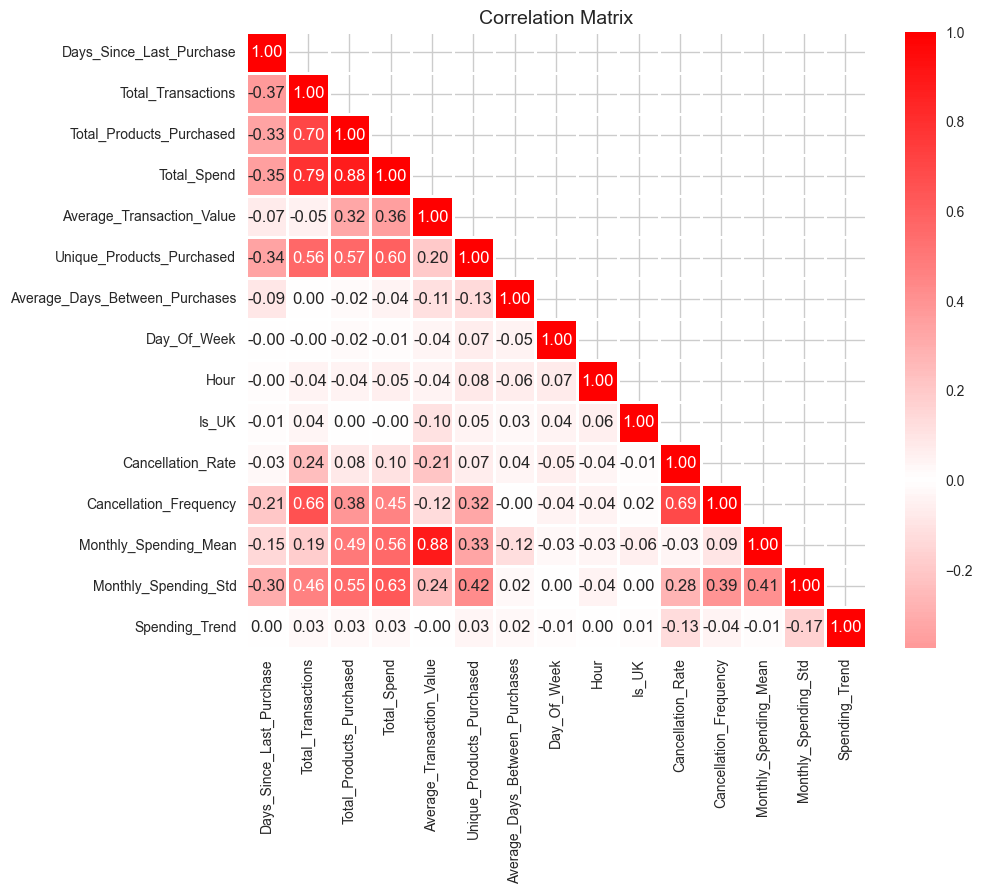

In [424]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()
custom_colors = ['#ff0000', '#ff7878', 'white', '#ff7878', '#ff0000']

# Define a custom colormap
colors = custom_colors
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

The heatmap reveals several pairs of variables with strong correlations:

    Monthly_Spending_Mean and Average_Transaction_Value
    Total_Spend and Total_Products_Purchased
    Total_Transactions and Total_Spend
    Cancellation_Rate and Cancellation_Frequency
    Total_Transactions and Total_Products_Purchased

These correlations suggest that these variables tend to vary together, indicating multicollinearity among them.

# ALGORITHM

- Feature Scaling

In [425]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Rate,Cancellation_Frequency,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.347823,-0.481895,-0.764318,-0.814477,-1.325378,-0.908578,-0.315888,1,-1.086598,1,2.333712,0.383328,-1.340388,-0.715764,0.087785
1,12347.0,-0.904314,0.691819,2.038307,2.361547,1.550719,0.806024,-0.126482,1,0.646419,0,-0.593527,-0.535349,1.004253,1.267951,0.114107
2,12348.0,-0.169311,-0.012410,1.894641,0.244620,0.353015,-0.572381,0.706444,3,2.812690,0,-0.593527,-0.535349,0.027865,0.470005,-0.504150
3,12349.0,-0.743217,-0.716638,-0.045989,0.259586,5.483066,0.284920,-0.315888,0,-1.519852,0,-0.593527,-0.535349,4.209965,-0.715764,0.087785
4,12350.0,2.196795,-0.716638,-0.540838,-0.597535,0.049810,-0.656430,-0.315888,2,1.512928,0,-0.593527,-0.535349,-0.219312,-0.715764,0.087785


- Dimensionality Reduction

PCA (Principal Component Analysis). Here's why:

PCA is an excellent starting point because it works well in capturing linear relationships in the data, which is particularly relevant given the multicollinearity we identified in our dataset. It allows us to reduce the number of features in our dataset while still retaining a significant amount of the information, thus making our clustering analysis potentially more accurate and interpretable. Moreover, it is computationally efficient, which means it won't significantly increase the processing time.

In [ ]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)


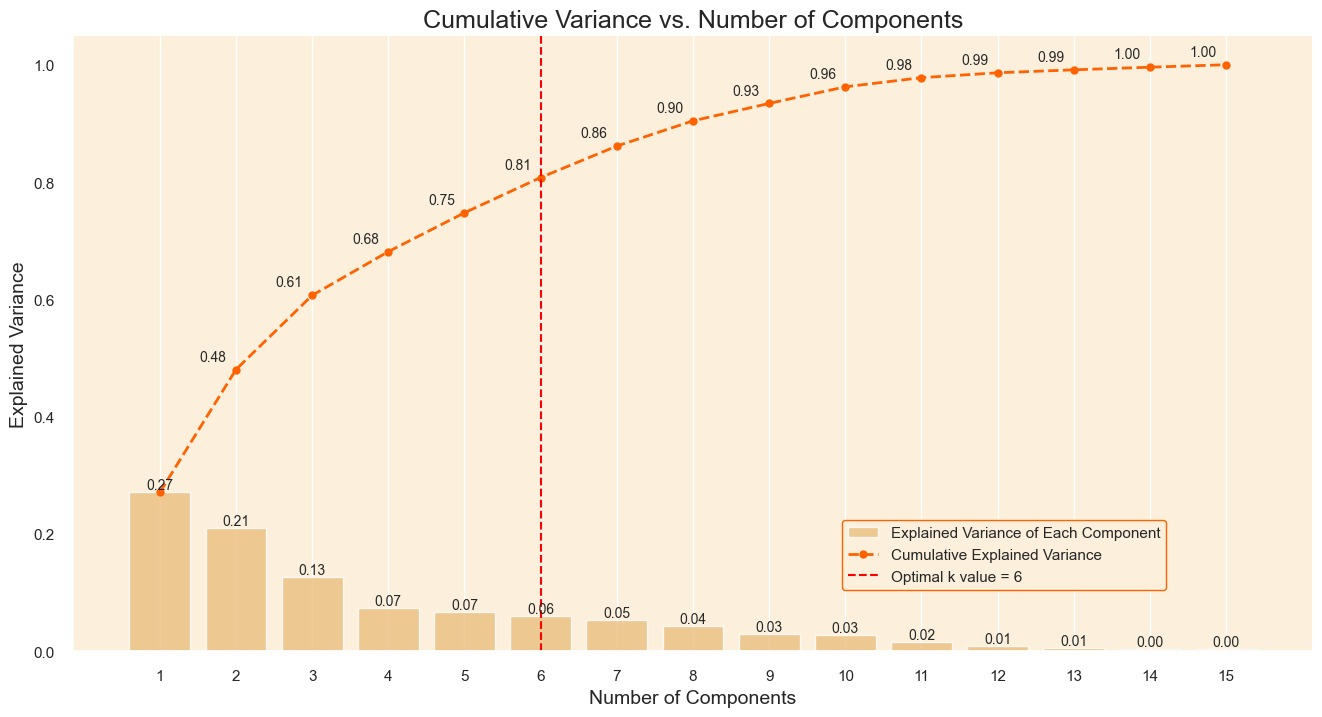

In [430]:

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(16, 8))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [431]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.039159,-1.817572,2.368551,1.602862,-0.277238,-1.916656
12347.0,3.425947,-1.315842,-1.939344,-0.742870,-0.167968,0.740400
12348.0,0.637681,0.613613,-0.712994,-0.604984,-0.776087,2.160252
12349.0,1.939447,-2.633388,-5.771425,1.922626,1.080417,-1.015514
12350.0,-1.994438,-0.544532,-0.721923,0.318996,-1.465351,-0.082106


In [432]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.219931,-0.017328,-0.048262,0.317888,-0.184430,-0.394818
Total_Transactions,0.382722,0.018183,0.239232,-0.214562,-0.031574,-0.059624
Total_Products_Purchased,0.410447,0.014013,-0.065451,-0.131800,0.035329,-0.032144
Total_Spend,0.438368,0.016739,-0.059551,-0.095663,0.019836,-0.055284
Average_Transaction_Value,0.181641,-0.010575,-0.561746,0.246933,0.061254,-0.048792
Unique_Products_Purchased,0.333308,0.067251,-0.018738,-0.208042,-0.219608,0.072670
Average_Days_Between_Purchases,-0.025062,-0.038664,0.127702,-0.169861,0.712658,0.281459
Day_Of_Week,-0.039251,0.993564,0.021673,0.045238,0.069648,-0.047104
Hour,-0.022434,0.057784,-0.005225,-0.151665,-0.611423,0.526753
Is_UK,-0.000378,0.007121,0.014448,-0.018838,-0.007946,0.013881
